In [16]:
import numpy as np
import os
import pandas as pd
import sys
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import  Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import category_encoders as ce
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
print(sys.version)
print(pd.__version__)

3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:57:06) 
[GCC 9.4.0]
1.4.2


In [18]:
import matplotlib.font_manager as fm
sns.set_style("darkgrid")

font = {
    'family': 'serif',
    'size': 26}

matplotlib.rc('font', **font)
# fm._rebuild()

In [19]:
rf_hpis = [ "bootstrap","criterion","max_features","min_samples_leaf","min_samples_split","imputation"]
ab_hpis = ["algorithm","max_depth","learning_rate","n_estimators","imputation"]
dt_hpis = ["criterion","max_features","min_samples_leaf","min_samples_split","imputation"]
et_hpis = ['bootstrap','criterion','max_features','min_samples_leaf','min_samples_split','imputation']
gb_hpis = ["learning_rate","criterion","n_estimators","max_depth","min_samples_split","min_samples_leaf","max_features","imputation"]
svm_hpis = ["C","coef0","gamma","kernel","shrinking","tol", "imputation"]

In [20]:
def read_dataset(model,hpis):
    path = "../performance_data/"+model+"_results_total.csv"
    df = pd.read_csv(path)
    X = df[hpis]
    y = df["CV_auc"]
    return X, y

In [71]:
# SVM, RF, AB, DT, ET, GB 
ml_model="ET"
ml_model_hpis = et_hpis
X, y = read_dataset(ml_model,ml_model_hpis)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, random_state=42,
)

/tmp/ipykernel_1042220/2300775867.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [72]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [73]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names   
    def fit(self, X, y = None):
        return self
    def transform(self, X, y=None):
        return X[self.feature_names] 

In [74]:
numeric_transformer = Pipeline(
    steps=[
    ("impute_median", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
                               ])
categorical_transformer = ce.OrdinalEncoder(handle_unknown="ignore")

In [75]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('cat_encoder', categorical_transformer, categorical_columns),
    ('num_encoder', numeric_transformer, numerical_columns)])

In [76]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
feat_name =  categorical_columns + numerical_columns

In [77]:
reg = RandomForestRegressor(random_state=1,n_jobs=-1)
reg.fit(X_train_transformed, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test_transformed))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0234


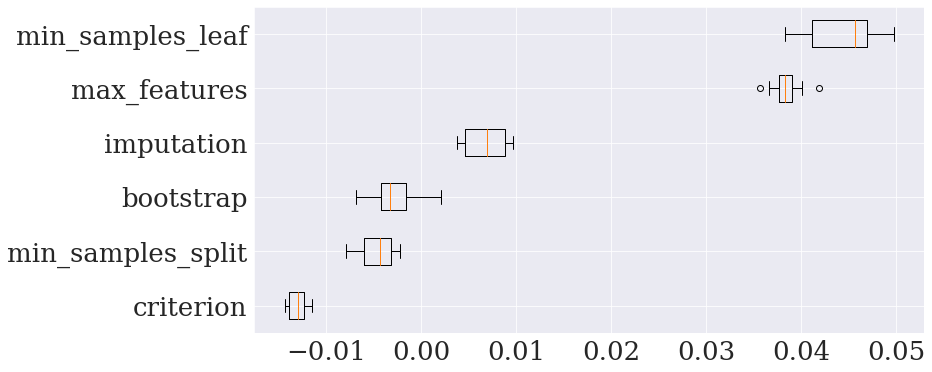

In [78]:
fig = plt.figure(figsize=(12, 6))

result = permutation_importance(reg, X_test_transformed, y_test, n_repeats=10, random_state=42, n_jobs=-1,)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_name)[sorted_idx],
)
# plt.title("Permutation Importance (test set) ")
# fig.tight_layout()
plt.savefig(f'../output/permotation_importance/{ml_model}_importance.pdf', bbox_inches = 'tight', pad_inches = 0, format='pdf')  
plt.show()